# Swaption Volatility Bootstrapping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from fredapi import Fred
from scipy.interpolate import interp1d
import scipy.special as special
import scipy.optimize as optimize

### Create Price Curve

In [2]:
def P(T,r):
    return 100*np.exp(-(r*T))

In [3]:
api_key = "9bfd3e0f52387a12fa0f09291c86655a"
fred = Fred(api_key=api_key)
df_CMT = pd.DataFrame()

df_CMT["DGS1"] = fred.get_series('DGS1')
df_CMT["DGS2"] = fred.get_series('DGS2')
df_CMT["DGS3"] = fred.get_series('DGS3')
df_CMT["DGS5"] = fred.get_series('DGS5')

df2_CMT = pd.DataFrame(df_CMT.iloc[len(df_CMT)-23,:])
df2_CMT["t"] = [1,2,3,5]
df2_CMT["P"] = P(df2_CMT.iloc[:,1],df2_CMT.iloc[:,0]/100)

In [4]:
df2_CMT

,2023-03-01 00:00:00,t,P
DGS1,5.06,1,95.065886
DGS2,4.89,2,90.683025
DGS3,4.61,3,87.083740
DGS5,4.27,5,80.775216


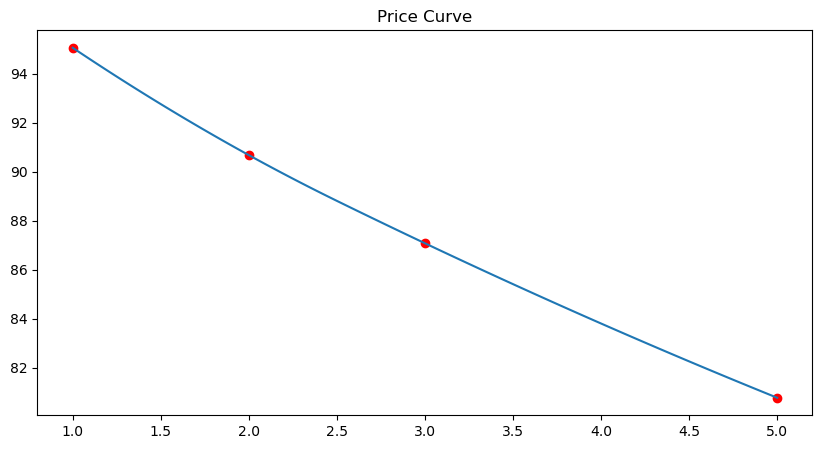

In [5]:
plt.figure(figsize=(10,5))
y = df2_CMT.iloc[:,2]
x = df2_CMT.iloc[:,1]

f = interp1d(x, y, kind='quadratic')

x_new = np.linspace(1, 5, 100)
y_new = f(x_new)

plt.plot(x_new,y_new)
plt.scatter(x,y,color="red")
plt.title("Price Curve")
plt.show()

### Swaption Volatility Bootstrap

In [16]:
# Get implied vol from a strike and ATM swaption price

def bs_price_fwd(K,v):
    opt= K*(special.ndtr((1/2)*v) - special.ndtr(-(1/2)*v))*100000
    return opt
class BSPriceTarget:
    def __init__(self,K,p):
        self.K=K
        self.p=p
    def __call__(self,sigma):
        return  bs_price_fwd(self.K,sigma)-self.p
def bs_implied_fwd(K, p, tol=1e-8,max_iter=1000, max_sigma=4):
    func=BSPriceTarget(K,p)
    sol=optimize.root_scalar(func,bracket=[-10,10],method="brentq")
    return sol.root

In [7]:
# ATM Swaption Prices
# [[1x1, 2x1, 3x1],[1x2, 2x2],[1x3]]
C = [[2278.1,4207.68,5883.36],[5461.08,9157.93],[8840.52]]
v = [[0,0,0],[0,0],[0]]
ep = [[0,0,0],[0,0],[0]]

In [8]:
# 1x1 Swaption
K2 = f(2)/f(1)
w2 = (1/K2)-1
chi12 = C[0][0]/((f(1)/100)*(1+w2))
v[0][0] = bs_implied_fwd(K2, chi12)
ep[0][0] = v[0][0]

In [9]:
# 1x2 Swaption
K3 = f(3)/f(1)
w3 = (1-K3)/(K2+K3)
chi13 = (C[1][0]/(f(1)/100) - w3*chi12)/(w3+1)
v[1][0] = bs_implied_fwd(K3, chi13)
ep[1][0] = v[1][0] - ep[0][0]

In [10]:
# 1x3 Swaption
K4 = f(4)/f(1)
w4 = (1-K4)/(K2+K3+K4)
chi14 = (C[2][0]/(f(1)/100) - w4*(chi12+chi13))/(w4+1)
v[2][0] = bs_implied_fwd(K4, chi14)
ep[2][0] = v[2][0] - ep[1][0] - ep[0][0]

In [11]:
# 2x1 Swaption
chi23 = C[0][1]/((f(2)/100)*(1+w3))
v[0][1] = bs_implied_fwd(K3, chi23)
ep[0][1] = np.sqrt(v[0][1]**2 - ep[1][0]**2)

In [12]:
# 2x2 Swaption
chi24 = (C[1][1]/(f(2)/100) - w4*chi23)/(w4+1)
v[1][1] = bs_implied_fwd(K4, chi24)
ep[1][1] = np.sqrt(v[1][1]**2 - (ep[1][0]+ep[2][0])**2) - ep[0][1]

In [13]:
# 3x1 Swaption
chi31 = C[2][0]/((f(3)/100)*(1+w4))
v[0][2] = bs_implied_fwd(K4, chi31)
ep[0][2] = np.sqrt(v[0][2]**2 - ep[2][0]**2 - ep[1][1]**2)

In [14]:
C, v, ep 

([[2278.1, 4207.68, 5883.36], [5461.08, 9157.93], [8840.52]],
 [[0.060076320438574665, 0.12158668147173601, 0.27763022429221873],
  [0.14788405889573147, 0.2709144564228415],
  [0.24509900910355883]],
 [[0.060076320438574665, 0.08410185597446075, 0.23383668635108432],
  [0.08780773845715681, 0.1137901534096072],
  [0.09721495020782736]])